# Heart Disease Classification

UCL medical classification using data from the [UCI data repository](https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data)

## Install package

In [ ]:
!pip install ucimlrepo
!pip install shap
!pip install lime --quiet

In [ ]:
!pip install streamlit_jupyter

  Using cached streamlit-1.44.1-py3-none-any.whl.metadata (8.9 kB)
Using cached streamlit-1.44.1-py3-none-any.whl (9.8 MB)
  Attempting uninstall: streamlit
    Found existing installation: streamlit 1.15.0
    Uninstalling streamlit-1.15.0:
      Successfully uninstalled streamlit-1.15.0


In [ ]:
# !pip install --upgrade streamlit_jupyter
# !pip install streamlit==1.15.0  # Replace with an appropriate older version

## Import package

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
import shap
import pickle

# feature selection
from sklearn.feature_selection import SelectKBest, f_classif

import joblib
from sklearn.metrics import roc_curve, auc

import streamlit as st

from streamlit_jupyter import StreamlitPatcher, tqdm


## Load the Dataset

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]


In [ ]:
df = pd.read_csv(url, names=columns, na_values="?")
df.head()

age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0

## Basic Overview of Dataset

In [ ]:
print("Shape of dataset:", df.shape)

Shape of dataset: (303, 14)


From above, we see that the table we are working with has 14 columns/features and 303 rows/samples

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


## Exploratory Data Analysis

### Check for missing value



In [ ]:
# count missing values
print('Number of NaN values:', df.isnull().sum().sum())

Number of NaN values: 6


### Data Cleaning

Recall that we had 6 missing values, now we will fill them up or delete them

In [ ]:
df = df.dropna()

### Check data types

In [ ]:
print('Data Types:', df.dtypes)

Data Types: age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
target        int64
dtype: object


### Check for duplicate rows
We want to ensure that participants were not recorded in the dataset more than once

In [ ]:
print('Number duplicate rows:', df.duplicated().sum())

Number duplicate rows: 0


There are no dupllicate rows, so we don't delete anything.

### Convert categorical variables

In [ ]:
df.loc[:, "sex"] = df["sex"].astype(int)
df.loc[:, "cp"] = df["cp"].astype(int)
df.loc[:, "fbs"] = df["fbs"].astype(int)
df.loc[:, "restecg"] =df["restecg"].astype(int)
df.loc[:, "exang"] = df["exang"].astype(int)
df.loc[:, "slope"] = df["slope"].astype(int)
df.loc[:, "ca"] = df["ca"].astype(int)
df.loc[:, "thal"] = df["thal"].astype(int)

### Get summary of the data

In [ ]:
df.describe()

age         sex          cp    trestbps        chol         fbs  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean    54.542088    0.676768    3.158249  131.693603  247.350168    0.144781   
std      9.049736    0.468500    0.964859   17.762806   51.997583    0.352474   
min     29.000000    0.000000    1.000000   94.000000  126.000000    0.000000   
25%     48.000000    0.000000    3.000000  120.000000  211.000000    0.000000   
50%     56.000000    1.000000    3.000000  130.000000  243.000000    0.000000   
75%     61.000000    1.000000    4.000000  140.000000  276.000000    0.000000   
max     77.000000    1.000000    4.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean     0.996633  149.599327    0.326599    1.055556    1.602694    0.676768   
std      0.994914   22.941562    0.469761    1.166123    0.618187    0.938965   
min      0.000000   71.000000    0.000000    0.000000    1.000000    0.000000   
25%      0.000000  133.000000    0.000000    0.000000    1.000000    0.000000   
50%      1.000000  153.000000    0.000000    0.800000    2.000000    0.000000   
75%      2.000000  166.000000    1.000000    1.600000    2.000000    1.000000   
max      2.000000  202.000000    1.000000    6.200000    3.000000    3.000000   

             thal      target  
count  297.000000  297.000000  
mean     4.730640    0.946128  
std      1.938629    1.234551  
min      3.000000    0.000000  
25%      3.000000    0.000000  
50%      3.000000    0.000000  
75%      7.000000    2.000000  
max      7.000000    4.000000

We notice that the youngest person in our dataset is 29 and the oldest is 77 and the average age of our participants is 54.

### Check class distribution


In [ ]:
df['target'].value_counts()

target
0    160
1     54
2     35
3     35
4     13
Name: count, dtype: int64

<Axes: title={'center': 'Target Distribution'}, xlabel='Heart Disease', ylabel='Count'>

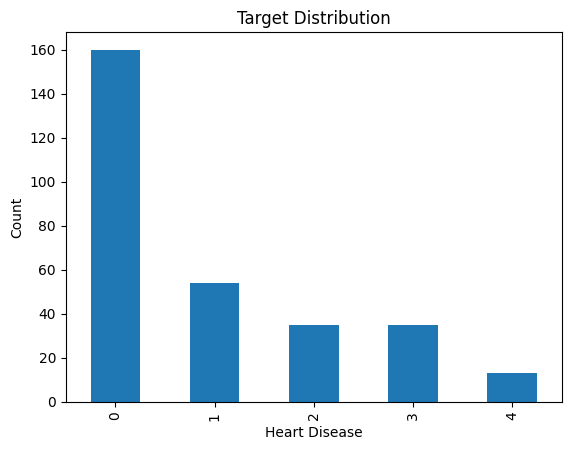

In [ ]:
df['target'].value_counts().plot(kind='bar', title='Target Distribution', ylabel='Count', xlabel='Heart Disease')


### Convert Heart disease to binary

As it currently is, the dataset has heart disease split into 4 categories, we would lie to change that to make it easier and and more understandable.

The ideal situation is one where 0 = no disease and 1 = presence of disease


<Axes: title={'center': 'Binary Target Distribution'}, xlabel='Heart Disease', ylabel='Count'>

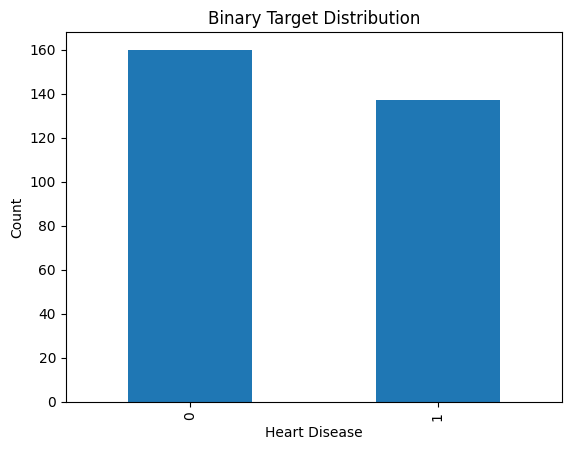

In [ ]:
df.loc[:, 'target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)

# visualize new distribution
df['target'].value_counts().plot(kind='bar', title='Binary Target Distribution', ylabel='Count', xlabel='Heart Disease')

### Pair plot

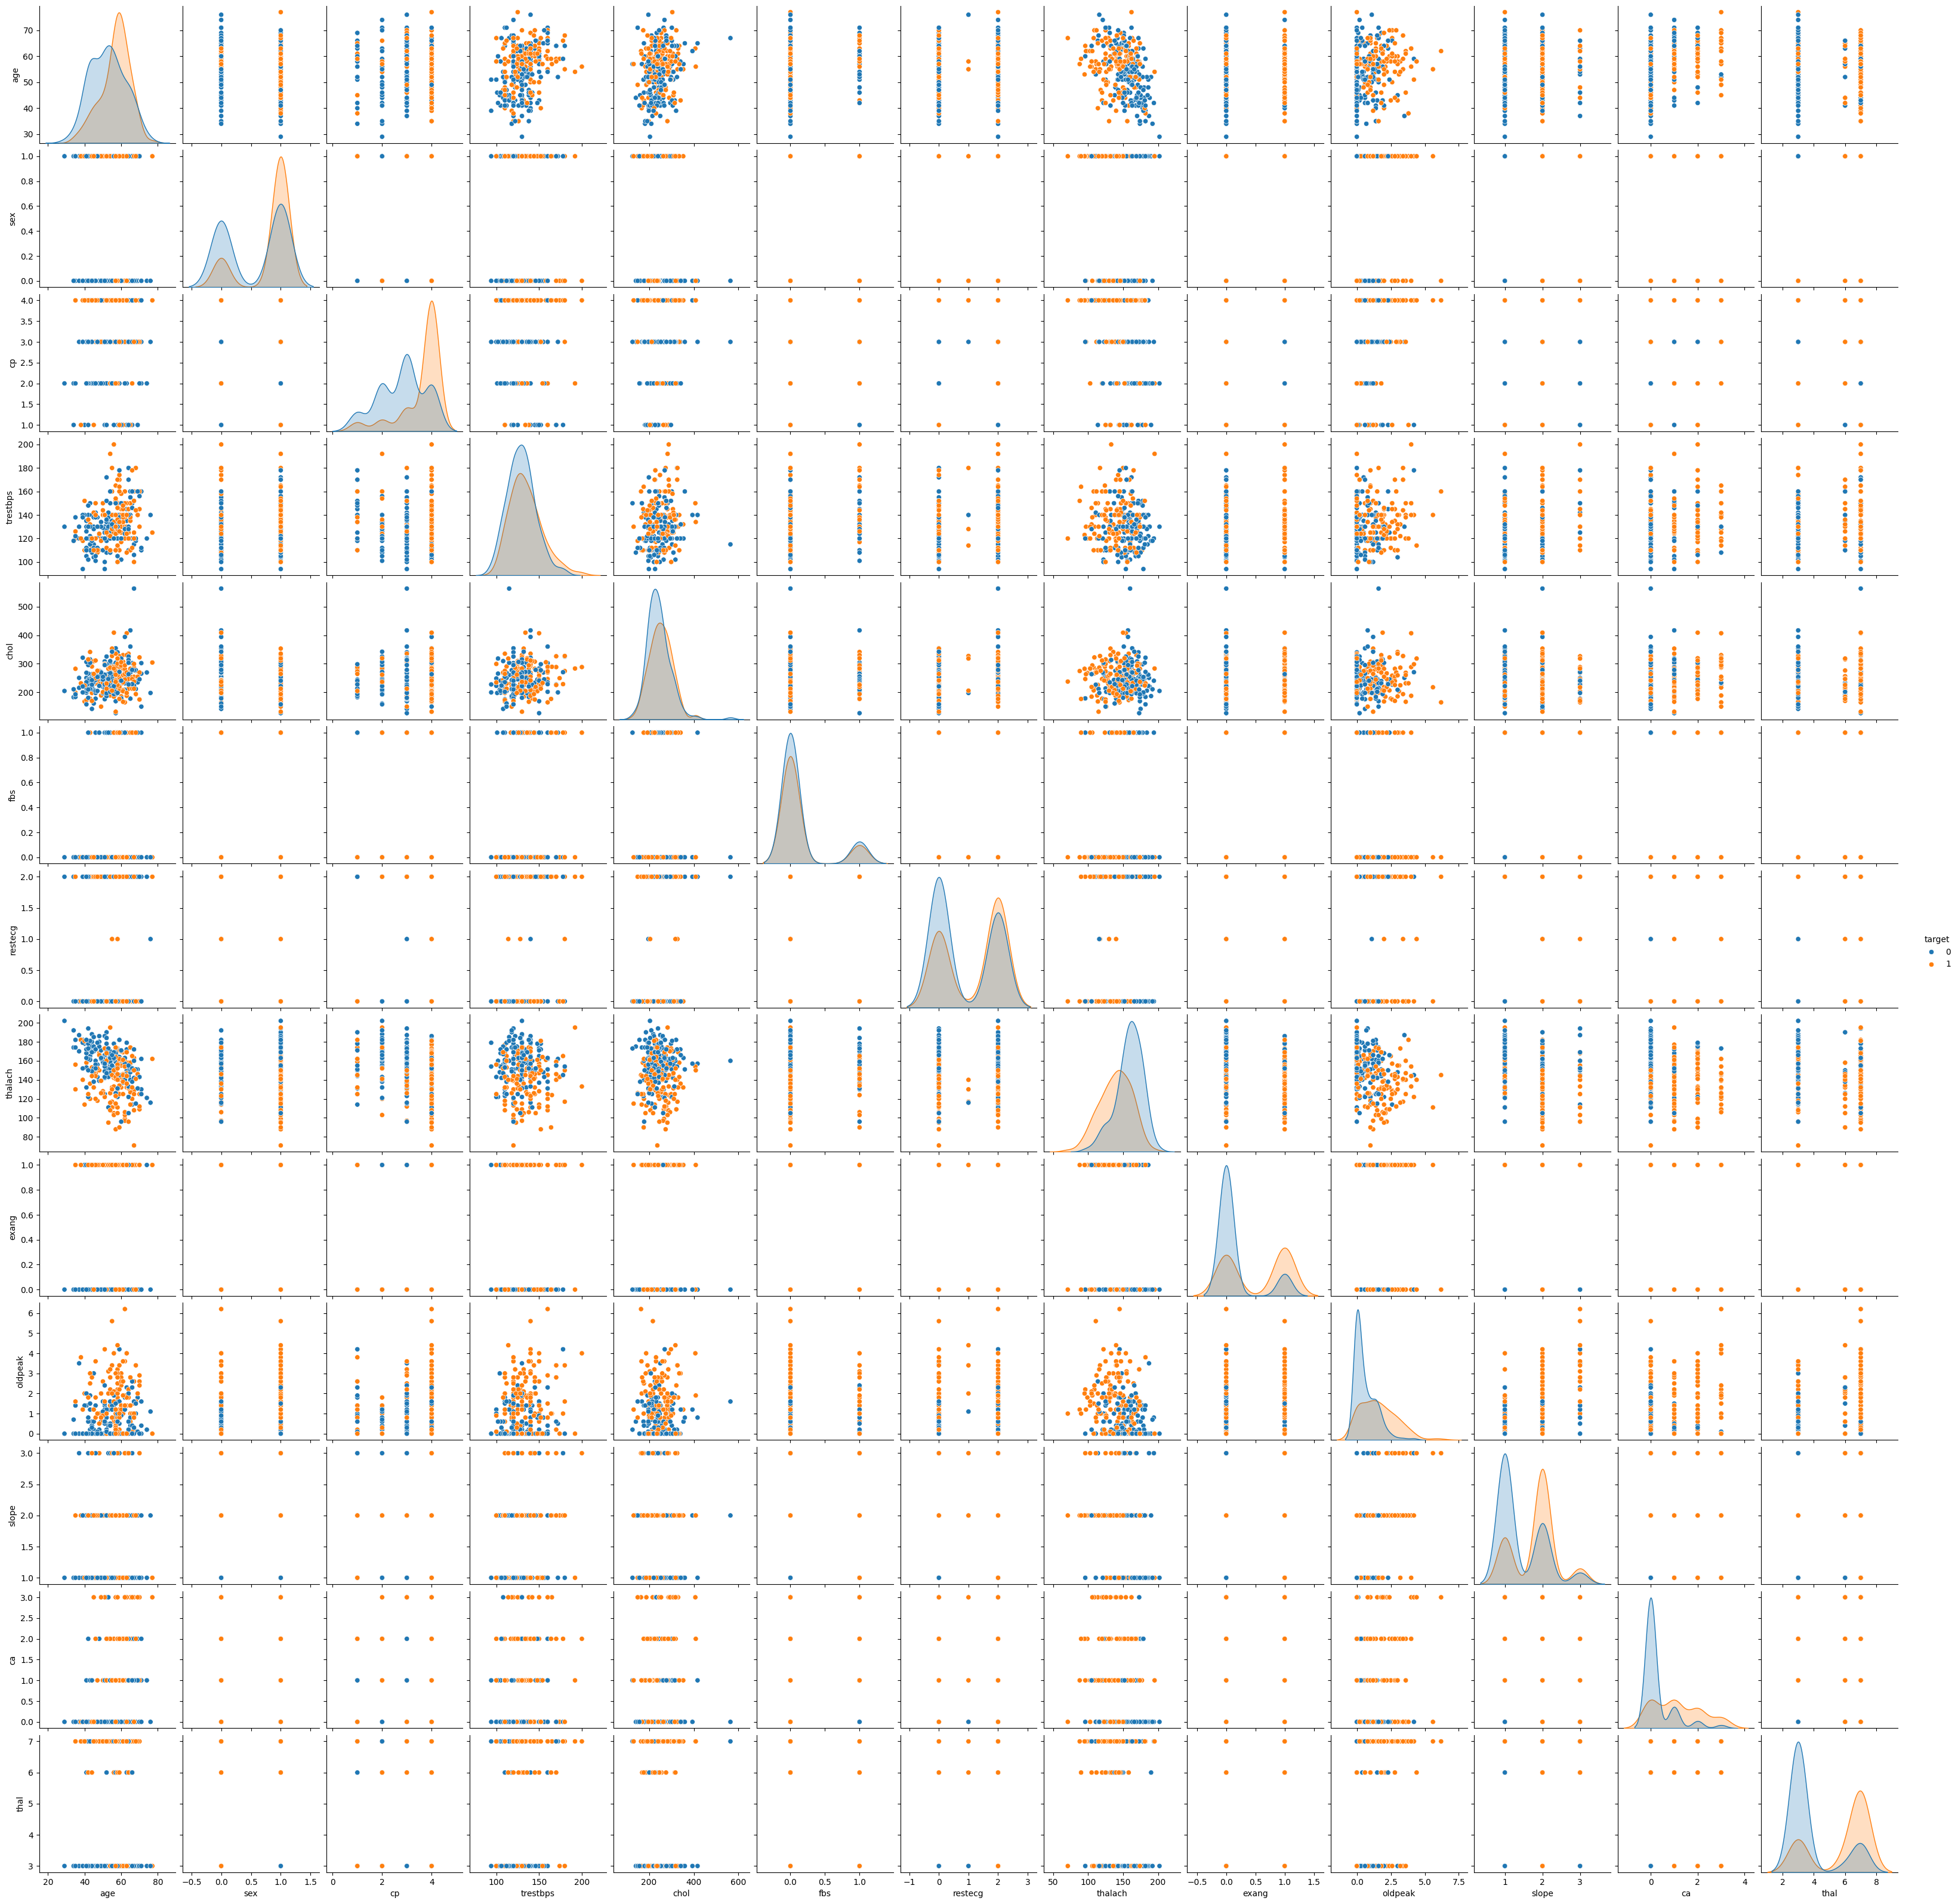

In [ ]:
features = df.columns
sns.pairplot(df[features], hue='target')


### Correlation matrix

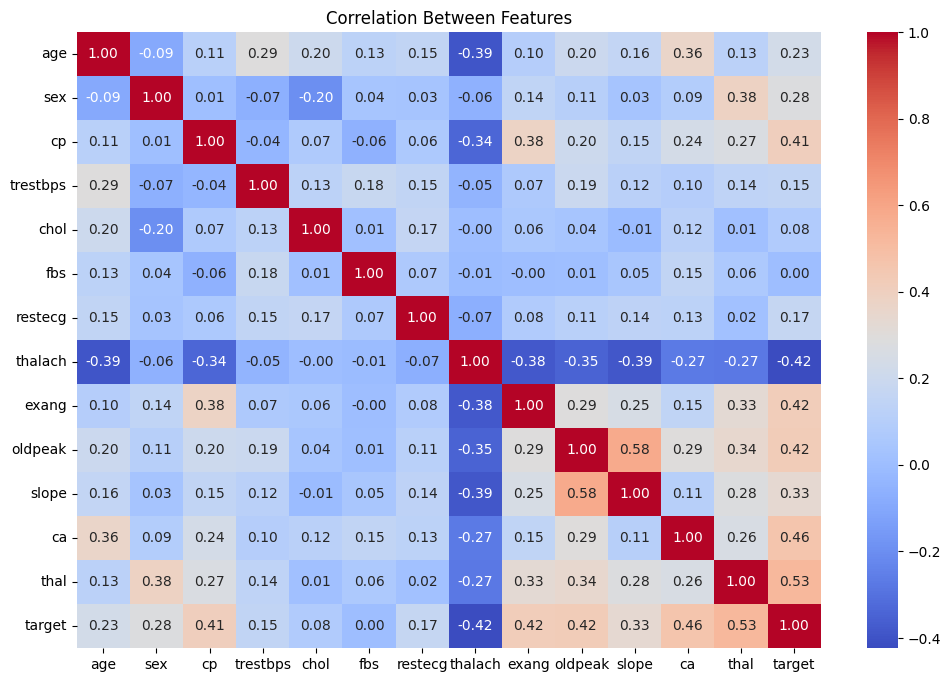

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap="coolwarm")
plt.title("Correlation Between Features")
plt.show()

### Histograms for numeric columns

Here we see the distribution of the values in the columns as well as outliers

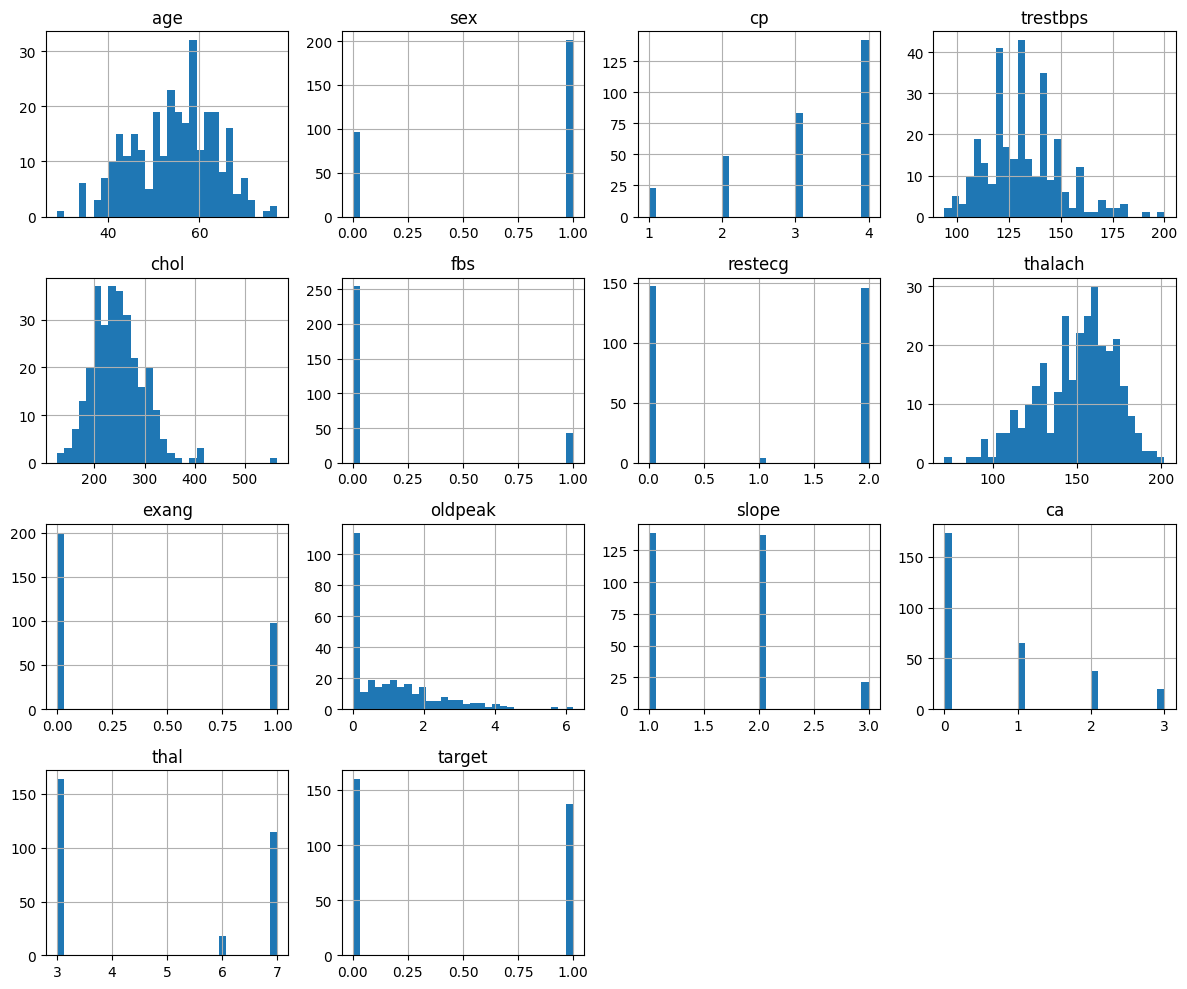

In [ ]:
df.hist(bins=30, figsize=(12, 10))
plt.tight_layout()
plt.show()

## Feature selection
Now that we have seen the features related to each other in the [correlation matrix of numeric columns](https://colab.research.google.com/drive/18DnJh0cNLWbjMVrJd5BryLknGruhYrKG#scrollTo=nDKmD0-CYc6r&line=1&uniqifier=1), we want to drop the columns that don't add any value to our results.

We will use SelectKBest + f_classif (ANOVA F-test) to select the top features that best explain the variation in the target variable (heart disease).

### Split features and labels

In [ ]:
X = df.drop('target', axis=1)
y = df['target']

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Select features

In [ ]:
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X_train, y_train)

In [ ]:
selector.get_support()

array([ True,  True,  True,  True, False, False, False,  True,  True,
        True,  True,  True,  True])

In [ ]:
# get selected feature names
selected_features = X.columns[selector.get_support()]

print("✅ Top Selected Features:")
print(selected_features)

✅ Top Selected Features:
Index(['age', 'sex', 'cp', 'trestbps', 'thalach', 'exang', 'oldpeak', 'slope',
       'ca', 'thal'],
      dtype='object')


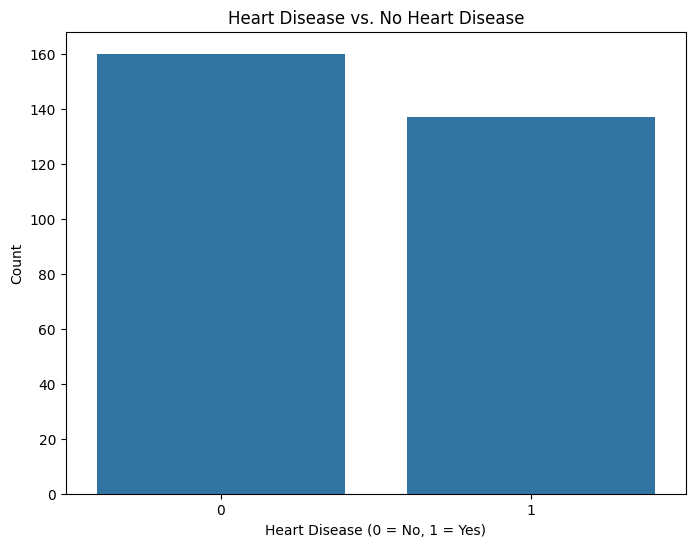

In [ ]:
# prompt: plot the heart disease vs no heart disease in a graph

# Assuming 'df' is your DataFrame as defined in the previous code.

plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df)
plt.title('Heart Disease vs. No Heart Disease')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()


Wee see there is no class imbalance, so no need to balance classes

## Model Training

In [ ]:
# use selected features
X_selected = X[selected_features]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

### Logistic regression (L2)

In [ ]:
from sklearn.linear_model import LogisticRegression

# initialize_model
lr_model = LogisticRegression(penalty='l2', random_state=42)

# train model
lr_model.fit(X_train, y_train)

# make predictions
lr_preds = lr_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# initialize_model
rf_model = RandomForestClassifier(random_state=42)

# train model
rf_model.fit(X_train, y_train)

# make predictions
rf_preds = rf_model.predict(X_test)

### SVM

In [ ]:
from sklearn.svm import SVC
# initialize_model
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# train model
svm_model.fit(X_train, y_train)

# make predictions
svm_preds = svm_model.predict(X_test)

### XGBoost

In [ ]:
from xgboost import XGBClassifier

# initialize_model
xgb_model = XGBClassifier(random_state=42)

# train model
xgb_model.fit(X_train, y_train)

# make predictions
xgb_preds = xgb_model.predict(X_test)

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# initialize_model
knn_model = KNeighborsClassifier()

# train model
knn_model.fit(X_train, y_train)

# make predictions
knn_preds = knn_model.predict(X_test)

## Model Evaluation

We will evaluate the models performances based on:

Accuracy

Precision

Recall

F1-Score

Confusion Matrix

ROC-AUC Score

### Metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay

In [ ]:
print(X_train.columns)

Index(['age', 'sex', 'cp', 'trestbps', 'thalach', 'exang', 'oldpeak', 'slope',
       'ca', 'thal'],
      dtype='object')


In [ ]:
min_values = df.min()
min_values


age          29.0
sex           0.0
cp            1.0
trestbps     94.0
chol        126.0
fbs           0.0
restecg       0.0
thalach      71.0
exang         0.0
oldpeak       0.0
slope         1.0
ca            0.0
thal          3.0
target        0.0
dtype: float64

In [ ]:
# Assuming 'df' is your DataFrame as defined in the previous code.
min_values = df.max()
min_values

age          77.0
sex           1.0
cp            4.0
trestbps    200.0
chol        564.0
fbs           1.0
restecg       2.0
thalach     202.0
exang         1.0
oldpeak       6.2
slope         3.0
ca            3.0
thal          7.0
target        1.0
dtype: float64

#### L2 Logistic Regression

📌 Logistic Regression Evaluation
Accuracy: 0.9
Precision: 0.875
Recall: 0.875
F1 Score: 0.875

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92        36
           1       0.88      0.88      0.88        24

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



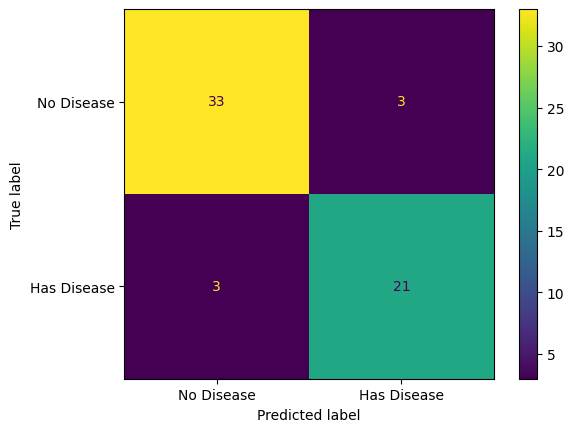

In [ ]:
# Metrics
print("📌 Logistic Regression Evaluation")
print("Accuracy:", accuracy_score(y_test, lr_preds))
print("Precision:", precision_score(y_test, lr_preds))
print("Recall:", recall_score(y_test, lr_preds))
print("F1 Score:", f1_score(y_test, lr_preds))
print("\nClassification Report:\n", classification_report(y_test, lr_preds))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, lr_preds, display_labels=["No Disease", "Has Disease"])


#### RF

📌 Random Forest Evaluation
Accuracy: 0.85
Precision: 0.8
Recall: 0.8333333333333334
F1 Score: 0.8163265306122449

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.87        36
           1       0.80      0.83      0.82        24

    accuracy                           0.85        60
   macro avg       0.84      0.85      0.84        60
weighted avg       0.85      0.85      0.85        60



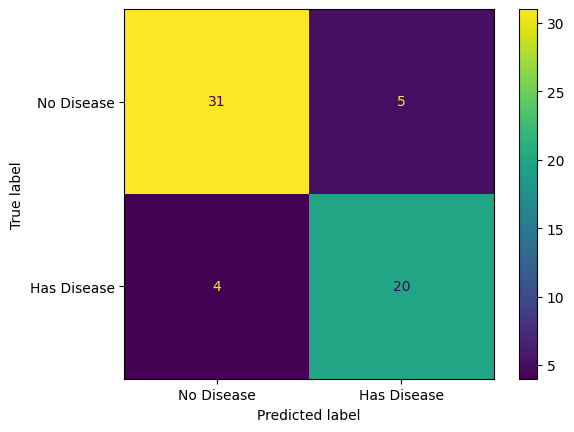

In [ ]:
# Metrics
print("📌 Random Forest Evaluation")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print("Precision:", precision_score(y_test, rf_preds))
print("Recall:", recall_score(y_test, rf_preds))
print("F1 Score:", f1_score(y_test, rf_preds))
print("\nClassification Report:\n", classification_report(y_test, rf_preds))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, rf_preds, display_labels=["No Disease", "Has Disease"])


#### SVM

📌 SVM Evaluation
Accuracy: 0.9
Precision: 0.9090909090909091
Recall: 0.8333333333333334
F1 Score: 0.8695652173913043

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92        36
           1       0.91      0.83      0.87        24

    accuracy                           0.90        60
   macro avg       0.90      0.89      0.89        60
weighted avg       0.90      0.90      0.90        60



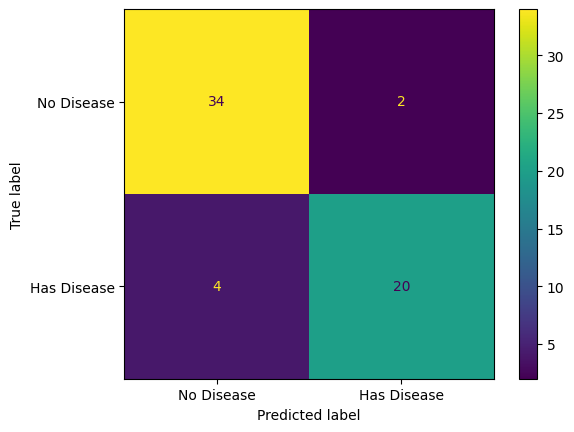

In [ ]:
# Metrics
print("📌 SVM Evaluation")
print("Accuracy:", accuracy_score(y_test, svm_preds))
print("Precision:", precision_score(y_test, svm_preds))
print("Recall:", recall_score(y_test, svm_preds))
print("F1 Score:", f1_score(y_test, svm_preds))
print("\nClassification Report:\n", classification_report(y_test, svm_preds))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, svm_preds, display_labels=["No Disease", "Has Disease"])


#### XGBoost

📌 XGBoost Evaluation
Accuracy: 0.8
Precision: 0.7307692307692307
Recall: 0.7916666666666666
F1 Score: 0.76

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83        36
           1       0.73      0.79      0.76        24

    accuracy                           0.80        60
   macro avg       0.79      0.80      0.79        60
weighted avg       0.80      0.80      0.80        60



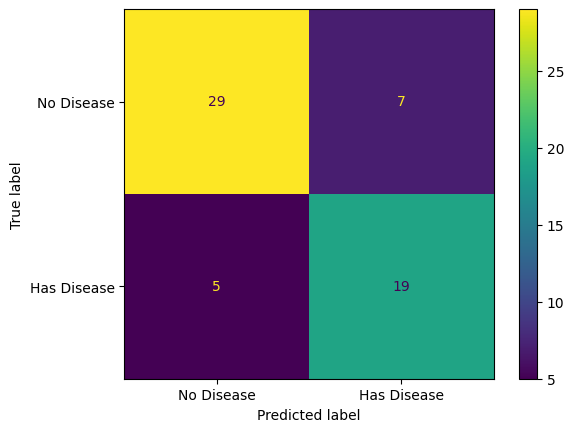

In [ ]:
# Metrics
print("📌 XGBoost Evaluation")
print("Accuracy:", accuracy_score(y_test, xgb_preds))
print("Precision:", precision_score(y_test, xgb_preds))
print("Recall:", recall_score(y_test, xgb_preds))
print("F1 Score:", f1_score(y_test, xgb_preds))
print("\nClassification Report:\n", classification_report(y_test, xgb_preds))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, xgb_preds, display_labels=["No Disease", "Has Disease"])


#### KNN

📌 KNN Evaluation
Accuracy: 0.6666666666666666
Precision: 0.5909090909090909
Recall: 0.5416666666666666
F1 Score: 0.5652173913043478

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.75      0.73        36
           1       0.59      0.54      0.57        24

    accuracy                           0.67        60
   macro avg       0.65      0.65      0.65        60
weighted avg       0.66      0.67      0.66        60



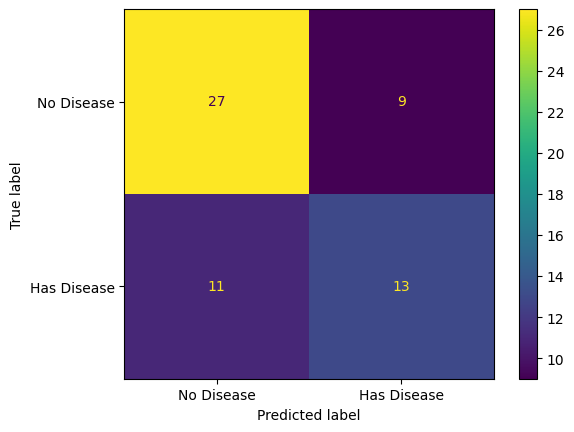

In [ ]:
# Metrics
print("📌 KNN Evaluation")
print("Accuracy:", accuracy_score(y_test, knn_preds))
print("Precision:", precision_score(y_test, knn_preds))
print("Recall:", recall_score(y_test, knn_preds))
print("F1 Score:", f1_score(y_test, knn_preds))
print("\nClassification Report:\n", classification_report(y_test, knn_preds))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, knn_preds, display_labels=["No Disease", "Has Disease"])


### Summary

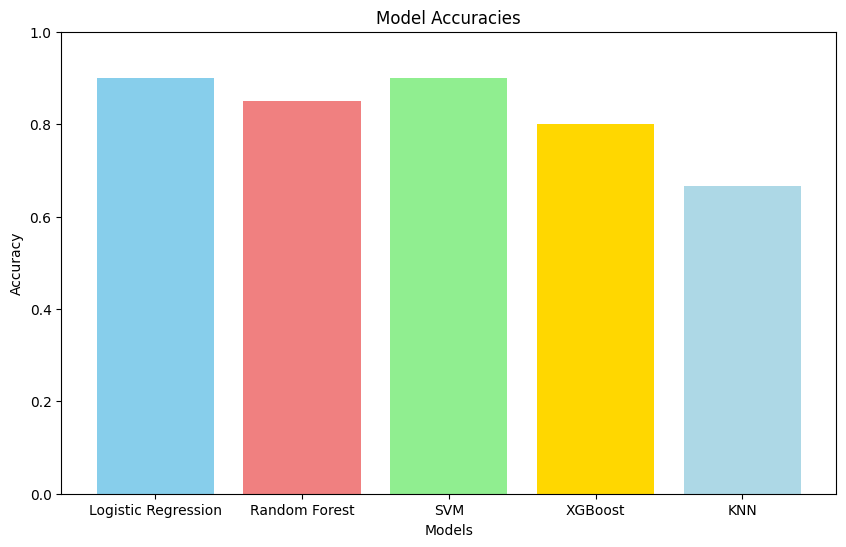

In [ ]:
lr_accuracy = accuracy_score(y_test, lr_preds)
rf_accuracy = accuracy_score(y_test, rf_preds)
svm_accuracy = accuracy_score(y_test, svm_preds)
xgb_accuracy = accuracy_score(y_test, xgb_preds)
knn_accuracy = accuracy_score(y_test, knn_preds)


models = ['Logistic Regression', 'Random Forest', 'SVM', 'XGBoost', 'KNN']
accuracies = [lr_accuracy, rf_accuracy, svm_accuracy, xgb_accuracy, knn_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'lightblue'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracies")
plt.ylim(0, 1.0) # Set y-axis limit to be between 0 and 1
plt.show()


### ROC-AUC

In [ ]:
# Get predicted probabilities
lr_probs = lr_model.predict_proba(X_test)[:, 1]
rf_probs = rf_model.predict_proba(X_test)[:, 1]
svm_probs = svm_model.predict_proba(X_test)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
knn_probs = knn_model.predict_proba(X_test)[:, 1]

# ROC AUC
print("LR ROC-AUC:", roc_auc_score(y_test, lr_probs))
print("RF ROC-AUC:", roc_auc_score(y_test, rf_probs))
print("SVM ROC-AUC:", roc_auc_score(y_test, svm_probs))
print("XGB ROC-AUC:", roc_auc_score(y_test, xgb_probs))
print("KNN ROC-AUC:", roc_auc_score(y_test, knn_probs))

LR ROC-AUC: 0.9398148148148149
RF ROC-AUC: 0.947337962962963
SVM ROC-AUC: 0.9594907407407408
XGB ROC-AUC: 0.9189814814814814
KNN ROC-AUC: 0.6851851851851851


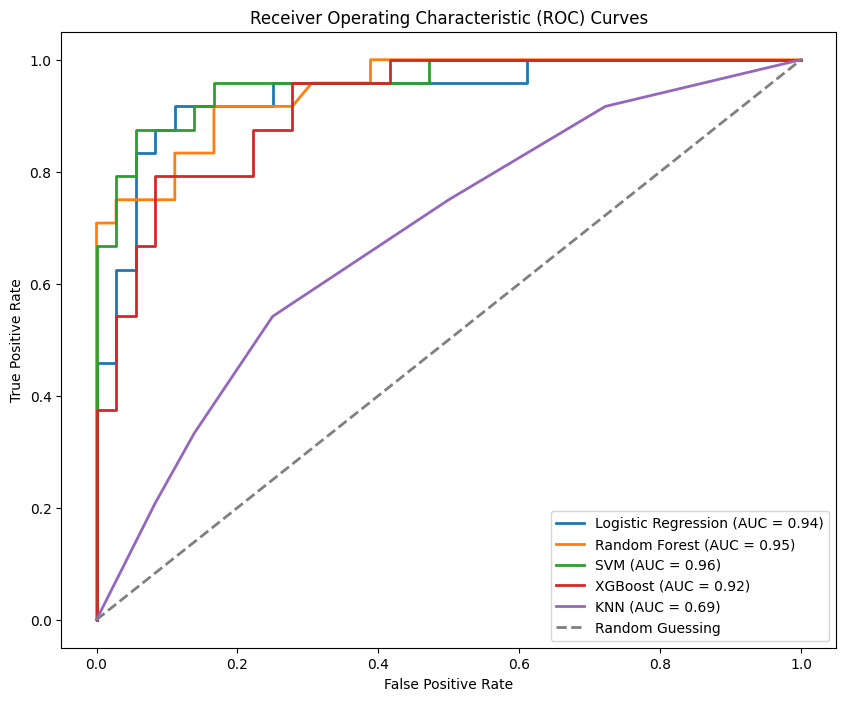

In [ ]:
# Calculate ROC curves and AUC scores
models = {
    "Logistic Regression": lr_probs,
    "Random Forest": rf_probs,
    "SVM": svm_probs,
    "XGBoost": xgb_probs,
    "KNN": knn_probs,
}

plt.figure(figsize=(10, 8))

for model_name, probs in models.items():
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="gray", label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curves")
plt.legend(loc="lower right")
plt.show()


## Model Explainability

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=["No Disease", "Has Disease"],
    mode='classification'
)

In [ ]:
i = 10  # Index of the test sample to explain

# Generate explanation
exp = explainer_lime.explain_instance(
    data_row = X_test.values[i],
    predict_fn = svm_model.predict_proba,
    num_features = 10
)

# Show explanation in notebook
exp.show_in_notebook(show_table=True)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


## Save best model

In [ ]:
joblib.dump(svm_model, 'svm_model.joblib')
best_model = svm_model

## Deploy model